# Main document

### Initialization 

In [1]:
import pypsa
import pandas as pd
from BaseNetwork import BuildBaseNetwork
from silent_optimize import silent_optimize
import matplotlib.pyplot as plt
import numpy as np


# Task A

In [2]:
# Basemodel with DK and DE
setup = {'DK': 
                {'OCGT': True,
                'solar': True,
                'offwind': True,
                'onwind': True},
        # 'DE': 
        #         {'OCGT': True,
        #         'solar': True,
        #         'offwind': True,
        #         'onwind': True,}
                # 'CCGT': True},
                }

BaseNetwork = BuildBaseNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)
silent_optimize(BaseNetwork.network)
# BaseNetwork.network.optimize(solver_name="gurobi",solver_options={"OutputFlag": 0})

Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 26.41it/s]


In [3]:
print(BaseNetwork.network.generators.p_nom_opt)

Generator
OCGT DK       5321.005850
solar DK      1224.534474
offwind DK     798.276665
onwind DK     5500.000000
Name: p_nom_opt, dtype: float64


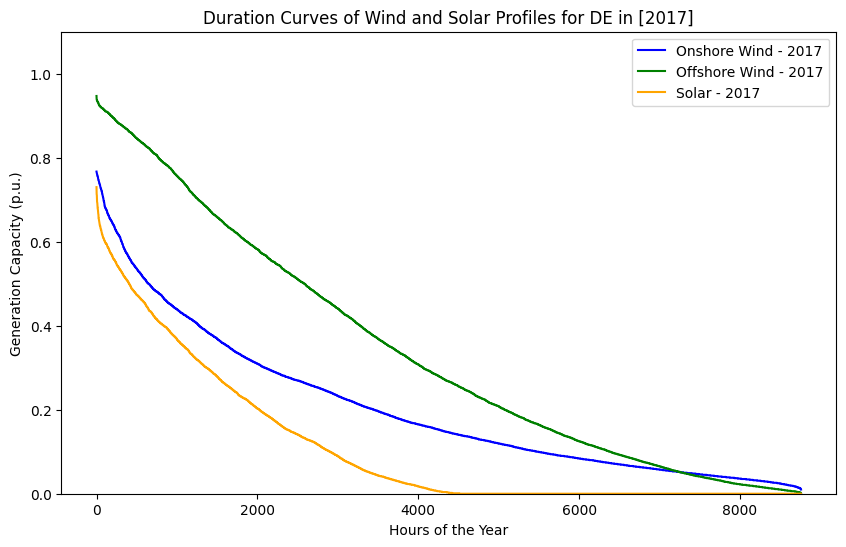

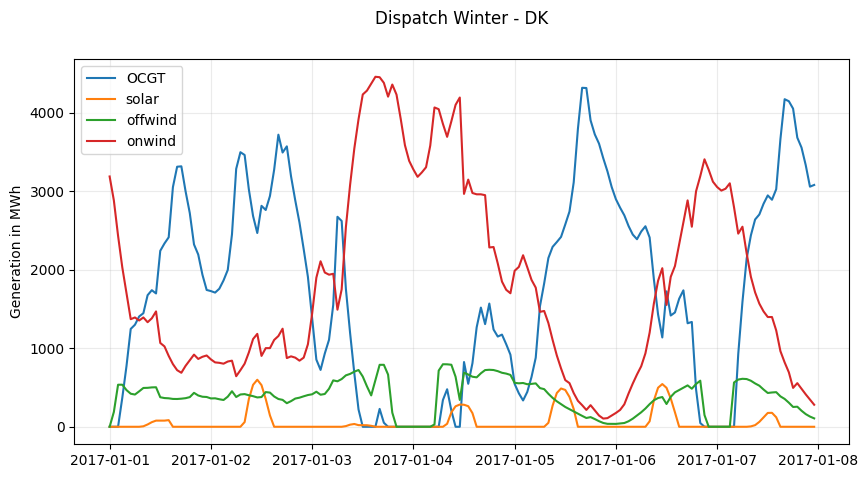

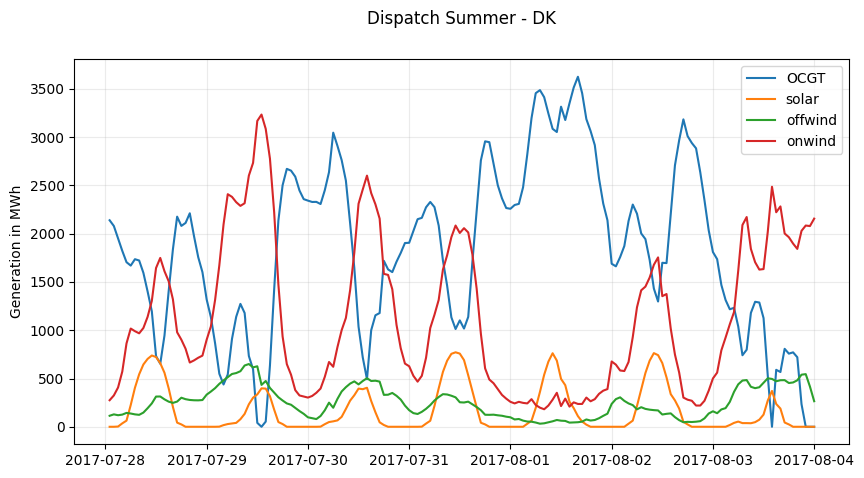

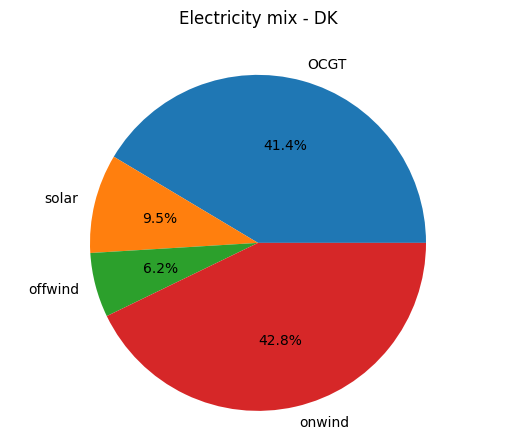

In [4]:
from PlotDispatch import PlotDispatch
from AnnualElectricityMix import AnnualElectricityMix
from DurationCurve import DurationCurve

region = 'DE'

years = [2017]

DurationCurve(years = years, region = region)

PlotDispatch(BaseNetwork)
AnnualElectricityMix(BaseNetwork)


# Task B

Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 20.28it/s]


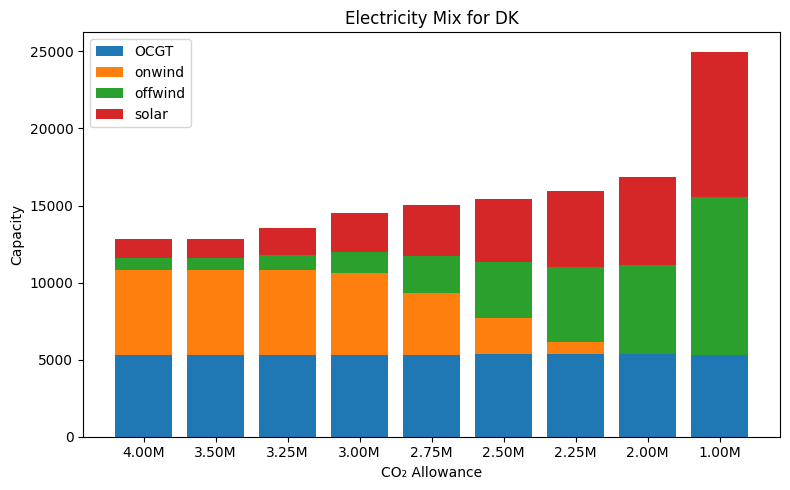

In [5]:
CO2_limits = [4_000_000, 3_500_000, 3_250_000, 3_000_000, 2_750_000, 2_500_000, 2_250_000, 2_000_000, 1_000_000]

network_CO2 = {CO2_limit: None for CO2_limit in CO2_limits}

generator_opt = {
    key: {
        'OCGT': [],
        'CCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

CO2_price = []
objectives = []

for CO2_limit in CO2_limits:
    # Initialize the base network
    NetworkCO2_Constraint = BuildBaseNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)

    #Add CO2 constraint to the network
    NetworkCO2_Constraint.network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=CO2_limit)

    # Solve the network with the CO2 constraint
    silent_optimize(NetworkCO2_Constraint.network)
    # NetworkCO2_Constraint.network.optimize(solver_name="gurobi",solver_options={"OutputFlag": 0})

    network_CO2[CO2_limit] = NetworkCO2_Constraint.network

    # Extract the results
    CO2_price.append(-NetworkCO2_Constraint.network.global_constraints.mu['CO2Limit'])
    objectives.append(NetworkCO2_Constraint.network.objective)
    generators = NetworkCO2_Constraint.network.generators.p_nom_opt.keys()
    for region in NetworkCO2_Constraint.regions:
        for generator in generators:
            if generator.split(' ')[1] == region:
                generator_opt[region][generator.split(' ')[0]].append(NetworkCO2_Constraint.network.generators.p_nom_opt[generator].sum())

x = np.arange(len(CO2_limits))  # [0, 1]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
    plt.title(f"Electricity Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Capacity")
    plt.legend()
    plt.tight_layout()
    plt.show()

Peak price day: 2017-01-21


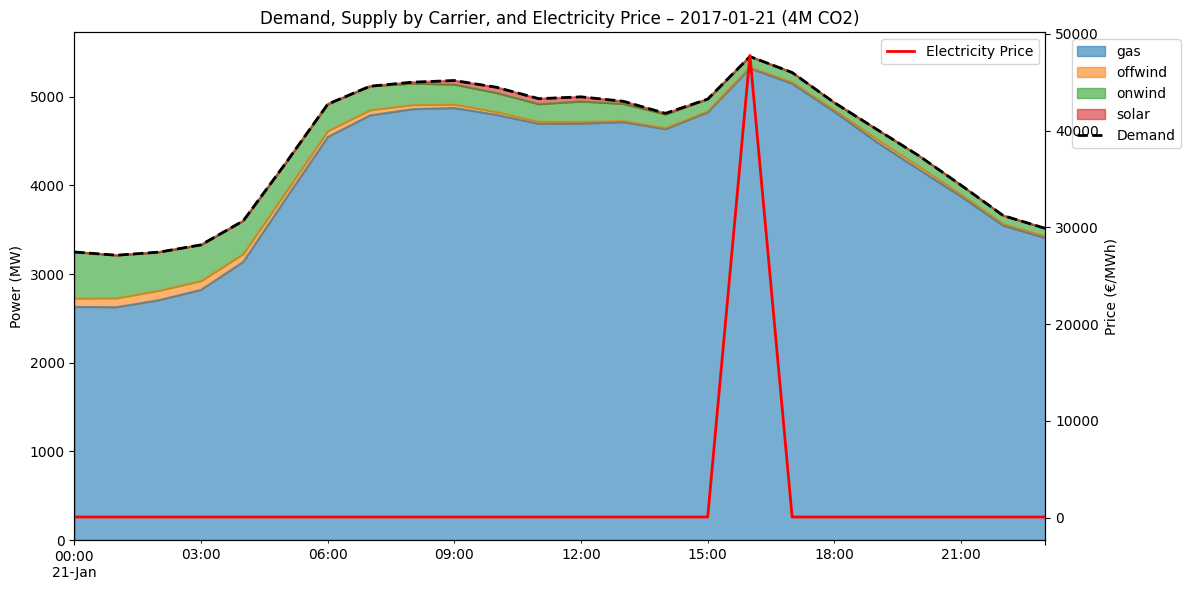

In [6]:
def plot_peak_day_supply_demand(network, title_suffix="", day=None):
    """
    Plots demand, supply by carrier, and average electricity price
    for the day with the highest average electricity price.

    Parameters:
        network: PyPSA network (already optimized)
        title_suffix: Optional string to add to the plot title
    """
    # 1. Find the peak price day
    avg_prices = network.buses_t.marginal_price.mean(axis=1)
    if day is None:
        peak_day = avg_prices.idxmax().strftime("%Y-%m-%d")
        ts_day = pd.date_range(f"{peak_day} 00:00", f"{peak_day} 23:00", freq="h")
    else:
        peak_day = day
        ts_day = pd.date_range(f"{peak_day} 00:00", f"{peak_day} 23:00", freq="h")
    
    print(f"Peak price day: {peak_day}")

    # 2. Demand
    demand = network.loads_t.p.loc[ts_day].sum(axis=1)

    # 3. Generation by carrier
    generation = network.generators_t.p.loc[ts_day]
    carrier_map = network.generators.carrier
    generation_by_carrier = generation.T.groupby(carrier_map).sum().T

    # 4. Electricity price (average across buses)
    price = network.buses_t.marginal_price.loc[ts_day].mean(axis=1)

    # 5. Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Stack plot of generation
    generation_by_carrier.plot.area(ax=ax1, stacked=True, alpha=0.6)
    
    # Demand line
    demand.plot(ax=ax1, label="Demand", color="black", linestyle="--", linewidth=2)

    ax1.set_ylabel("Power (MW)")
    ax1.set_title(f"Demand, Supply by Carrier, and Electricity Price – {peak_day} {title_suffix}")
    ax1.legend(loc="upper left", bbox_to_anchor=(1.02, 1))

    # Add price on secondary axis
    ax2 = ax1.twinx()
    price.plot(ax=ax2, color="red", label="Electricity Price", linewidth=2)
    ax2.set_ylabel("Price (€/MWh)")
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

# Select the day with the spike
n_4 = network_CO2[4_000_000] 

plot_peak_day_supply_demand(n_4, title_suffix="(4M CO2)")

In [7]:
# plt.plot(CO2_price, objectives, marker='o')
# plt.title("Objective vs CO₂ Price")
# plt.xlabel("CO₂ Price")
# plt.ylabel("Objective")
# plt.grid()
# plt.tight_layout()
# plt.show()

# Task C

Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 23.06it/s]


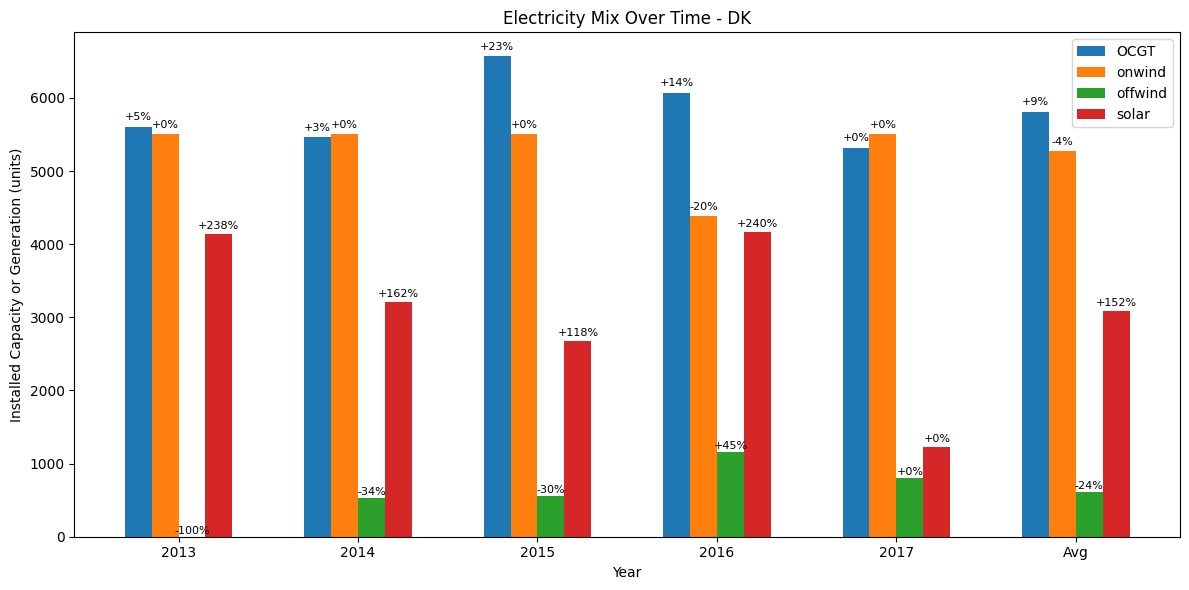

In [8]:
years = [2013, 2014, 2015, 2016, 2017]

network_year = {year: None for year in years}

generator_opt_year = {
    key: {
        'OCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

objectives_year = []

for year in years:
    # Initialize the base network
    Network_Yearly = BuildBaseNetwork(year = year, cost_year = 2030, setup = setup, demand_year=2019)

    # Solve the network for the specific year
    # Network_Yearly.network.optimize(solver_name="gurobi",solver_options={"OutputFlag": 0})
    silent_optimize(Network_Yearly.network)

    network_year[year] = Network_Yearly.network

    # Extract the results
    objectives_year.append(Network_Yearly.network.objective)
    generators_year = Network_Yearly.network.generators.p_nom_opt.keys()
    for region in Network_Yearly.regions:
        for generator in generators_year:
            if generator.split(' ')[1] == region:
                generator_opt_year[region][generator.split(' ')[0]].append(Network_Yearly.network.generators.p_nom_opt[generator].sum())

def plot_generation_mix_with_percentage_labels(years, generator_opt_year, base_year=2017):
    x = np.arange(len(years) + 1)  # One extra slot for 'Average'
    bar_width = 0.15

    for country, techs in generator_opt_year.items():
        plt.figure(figsize=(12, 6))

        for i, tech in enumerate(techs.keys()):
            values = techs.get(tech, [])
            if not values:
                continue

            # Get base value for normalization
            try:
                base_index = years.index(base_year)
                base_value = values[base_index]
            except (ValueError, IndexError):
                print(f"Warning: Base year {base_year} not found or no data for tech {tech}. Skipping label.")
                base_value = 0

            avg = np.mean(values)
            values_with_avg = values + [avg]

            bar_positions = x + i * bar_width
            bars = plt.bar(bar_positions, values_with_avg, width=bar_width, label=tech)

            # Add percentage labels relative to base year
            for j, (bar, val) in enumerate(zip(bars, values_with_avg)):
                if base_value != 0:
                    pct_change = ((val - base_value) / base_value) * 100
                    label = f"{pct_change:+.0f}%"
                else:
                    label = ""  # Avoid division by zero

                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + max(values_with_avg) * 0.01,
                    label,
                    ha='center',
                    va='bottom',
                    fontsize=8
                )

        xtick_labels = years + ['Avg']
        plt.xticks(x + bar_width * (len(techs.keys()) - 1) / 2, xtick_labels)

        plt.title(f"Electricity Mix Over Time - {country}")
        plt.xlabel("Year")
        plt.ylabel("Installed Capacity or Generation (units)")
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_generation_mix_with_percentage_labels(years, generator_opt_year, base_year=2017)

# Task D

Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 34.80it/s]


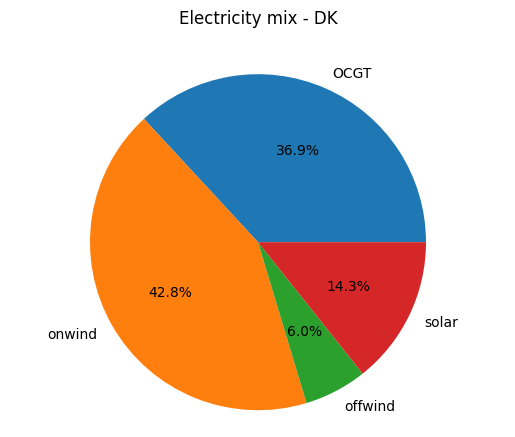

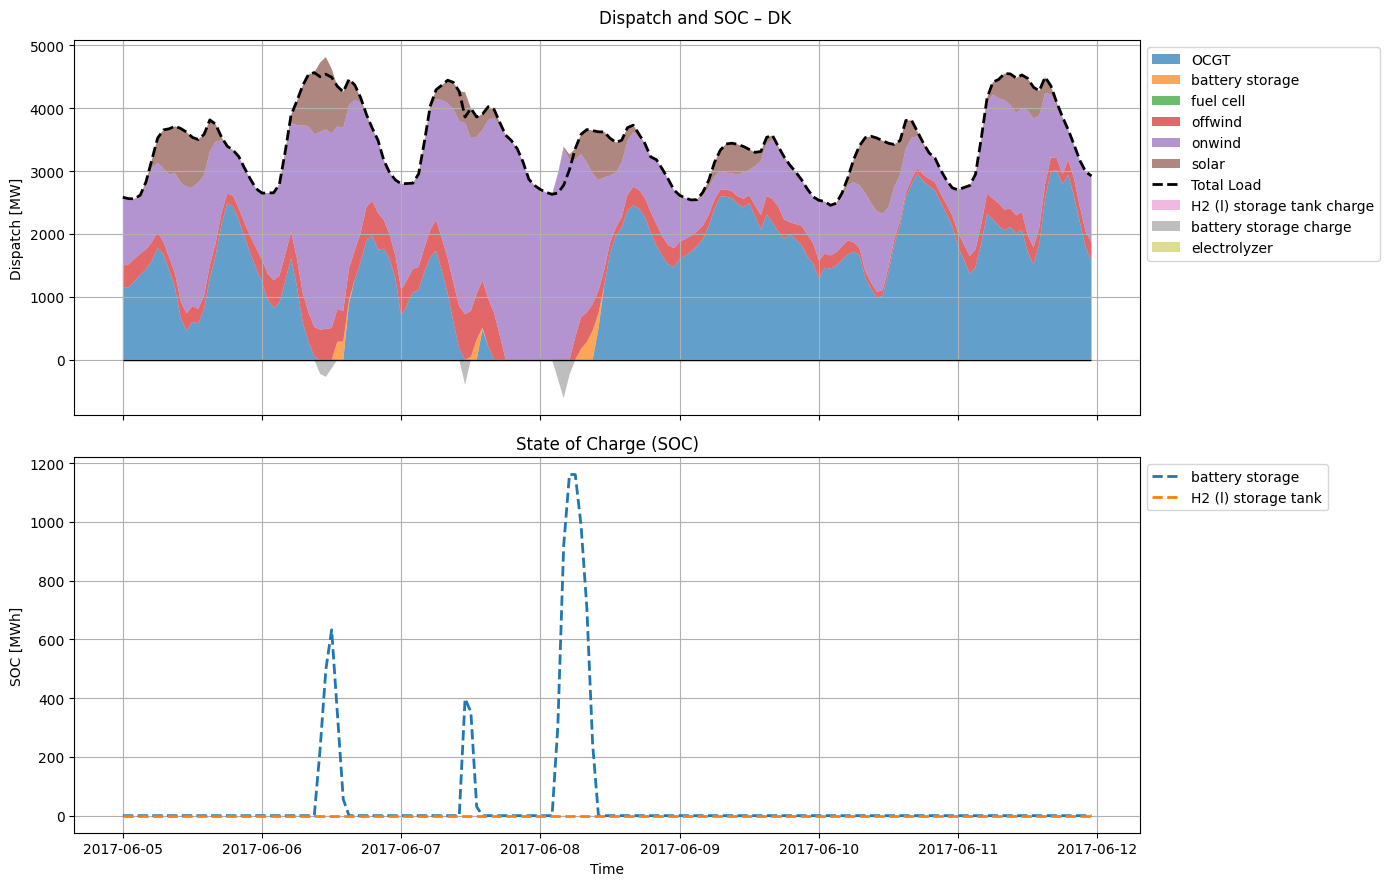

In [9]:
from ExpandedNetwork import ExpandedNetwork
from DispatchSoC import PlotDispatchSoC
from silent_optimize import silent_optimize
from AnnualElectricityMix import AnnualElectricityMix

year = 2017
cost_year = 2030
demand_year = 2019,
setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }}

Expanded_Network = ExpandedNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)
silent_optimize(Expanded_Network.network)

AnnualElectricityMix(Expanded_Network)
PlotDispatchSoC(Expanded_Network, start="2017-06-05 00:00", end="2017-06-11 23:00")


Hvordan viser man flot i et diagram to tal?

In [10]:
Expanded_Network.network.stores.e_nom_opt

Store
battery storage DK        1161.050848
H2 (l) storage tank DK       0.000000
Name: e_nom_opt, dtype: float64

# Task E

Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 35.05it/s]


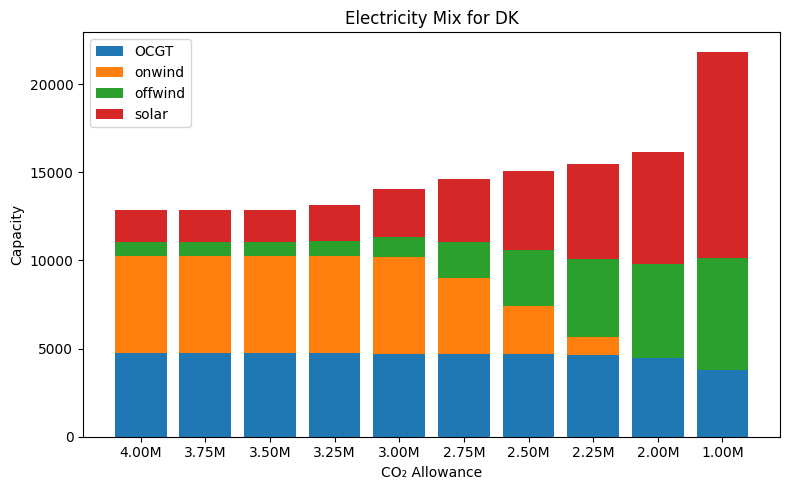

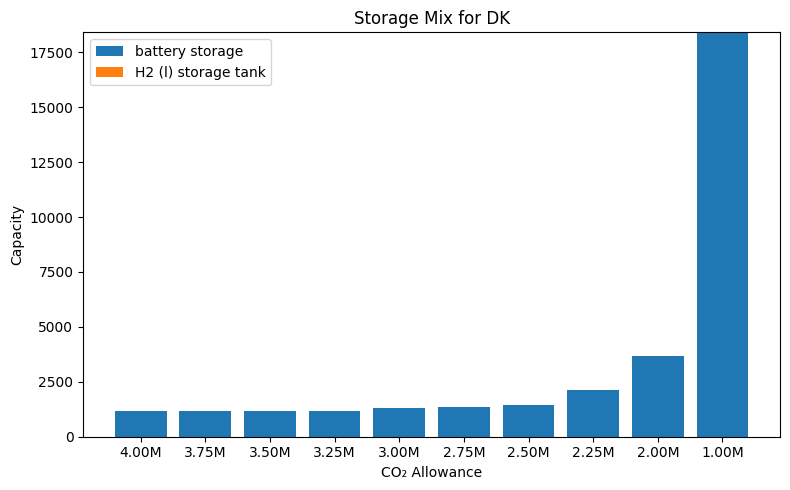

In [11]:
CO2_limits = [4_000_000, 3_750_000, 3_500_000, 3_250_000, 3_000_000, 2_750_000, 2_500_000, 2_250_000, 2_000_000, 1_000_000]

network_CO2 = {CO2_limit: None for CO2_limit in CO2_limits}

generator_opt = {
    key: {
        'OCGT': [],
        'onwind': [],
        'offwind': [],
        'solar': [] }
    for key in setup.keys()}

storage_opt = {
    key: {
        'battery storage': [],
        'H2 (l) storage tank': [] }
    for key in setup.keys()}

CO2_price = []
objectives = []

for CO2_limit in CO2_limits:
    # Initialize the base network
    NetworkCO2_Constraint = ExpandedNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)

    #Add CO2 constraint to the network
    NetworkCO2_Constraint.network.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=CO2_limit)

    # Solve the network with the CO2 constraint
    silent_optimize(NetworkCO2_Constraint.network)
    # NetworkCO2_Constraint.network.optimize(solver_name="gurobi",solver_options={"OutputFlag": 0})

    network_CO2[CO2_limit] = NetworkCO2_Constraint.network

    # Extract the results
    CO2_price.append(-NetworkCO2_Constraint.network.global_constraints.mu['CO2Limit'])
    objectives.append(NetworkCO2_Constraint.network.objective)
    generators = NetworkCO2_Constraint.network.generators.p_nom_opt.keys()
    for region in NetworkCO2_Constraint.regions:
        for generator in generators:
            if generator.split(' ')[1] == region:
                generator_opt[region][generator.split(' ')[0]].append(NetworkCO2_Constraint.network.generators.p_nom_opt[generator].sum())

    for region in NetworkCO2_Constraint.regions:
        for store in NetworkCO2_Constraint.network.stores.index:
            if store.endswith(region):
                store_type = store.replace(f" {region}", "")
                if store_type in storage_opt[region]:
                    storage_opt[region][store_type].append(NetworkCO2_Constraint.network.stores.e_nom_opt[store])

x = np.arange(len(CO2_limits))  # [0, 1]

for country, techs in generator_opt.items():
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
    plt.title(f"Electricity Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Capacity")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
for country, techs in storage_opt.items(): 
    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(CO2_limits))  # for stacking

    for tech, values in techs.items():
        if values:  # skip empty lists
            plt.bar(x, values, bottom=bottom, label=tech)
            bottom += np.array(values)

    plt.xticks(x, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
    plt.title(f"Storage Mix for {country}")
    plt.xlabel("CO₂ Allowance")
    plt.ylabel("Capacity")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [12]:
[val for val in CO2_price]

[-0.0,
 -0.0,
 -0.0,
 4.953515221634973,
 28.503783404118963,
 57.541259620811275,
 82.13552090309543,
 118.28371684092292,
 154.82282239293596,
 486.7054355917256]

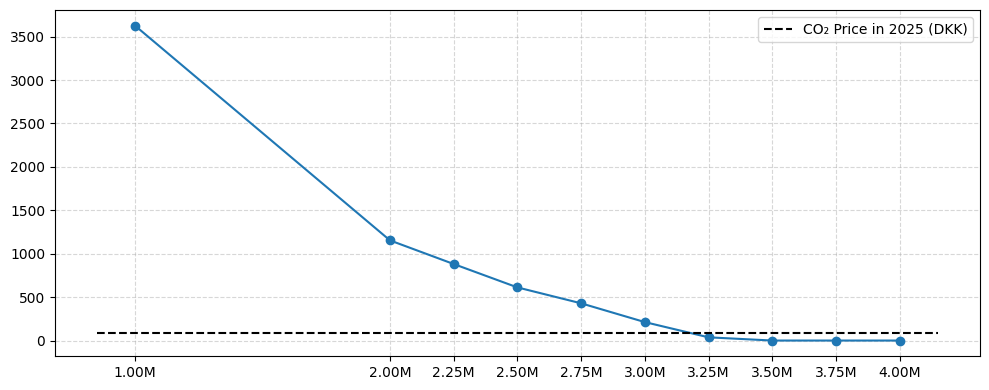

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(CO2_limits, [val * 7.45 for val in CO2_price], marker='o')
plt.xticks(CO2_limits, [f"{val/1_000_000:.2f}M" for val in CO2_limits])
# Force axis limits update before hlines
plt.gca().relim()
plt.gca().autoscale_view()

# Get x-limits from the plot
xmin, xmax = plt.xlim()
plt.hlines(y=85.2, xmin=xmin, xmax=xmax, color='black', linestyle='--', label='CO₂ Price in 2025 (DKK)')

plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Task F 

Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00,  9.02it/s]


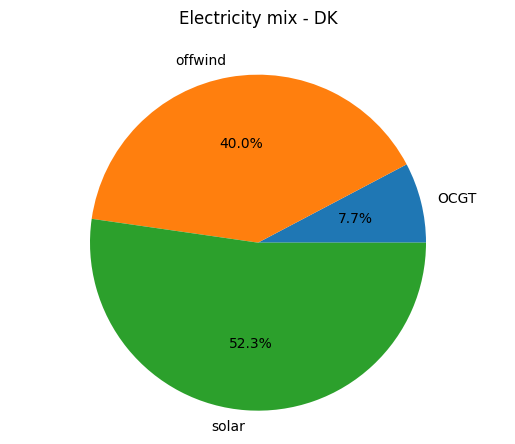

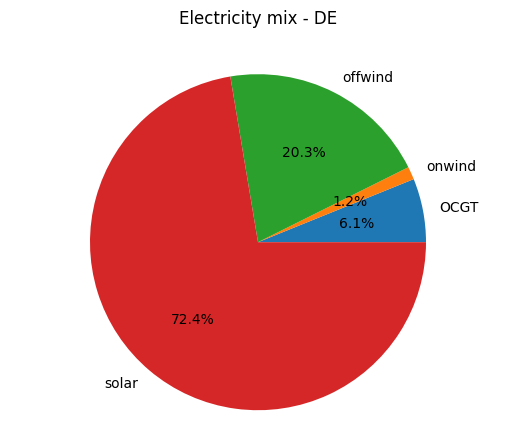

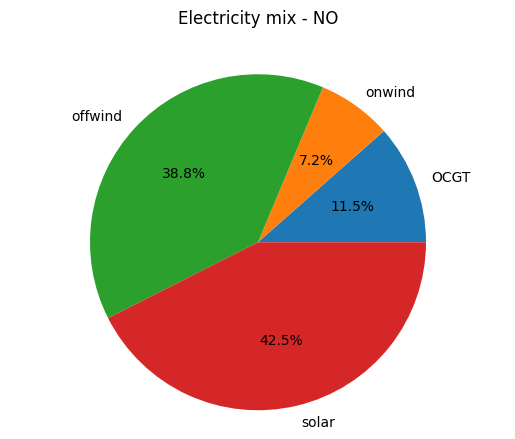

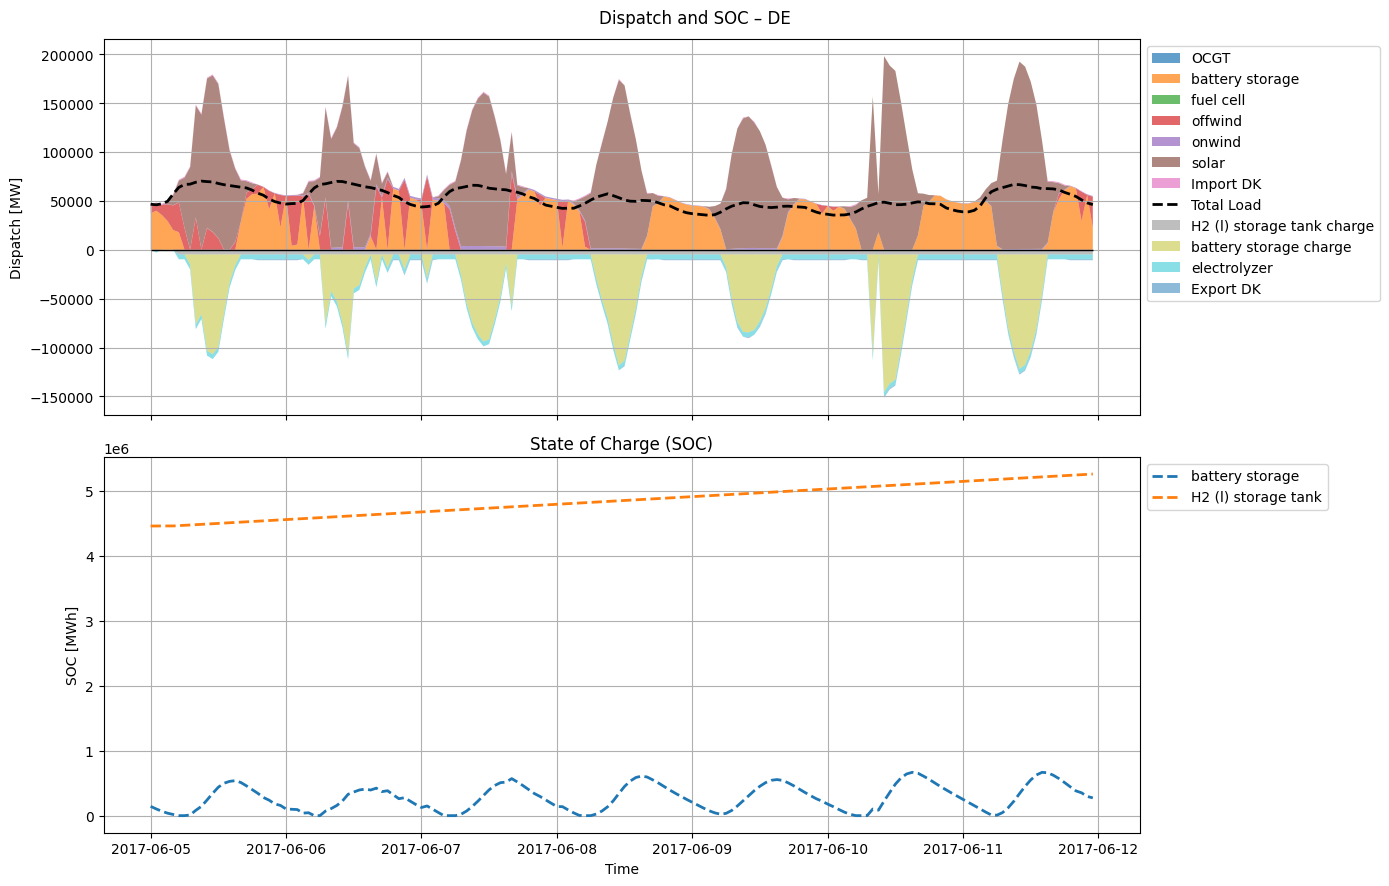

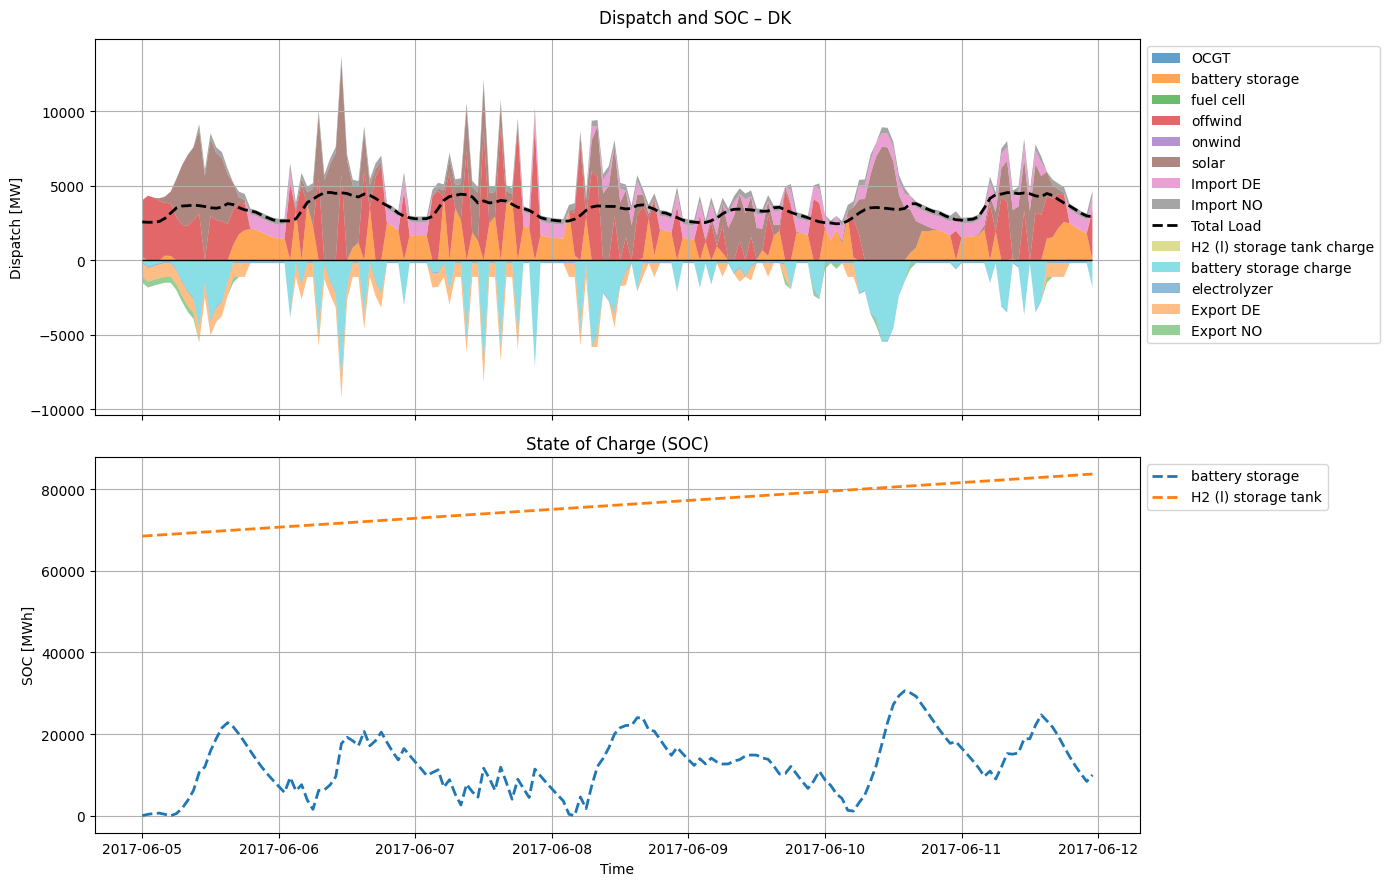

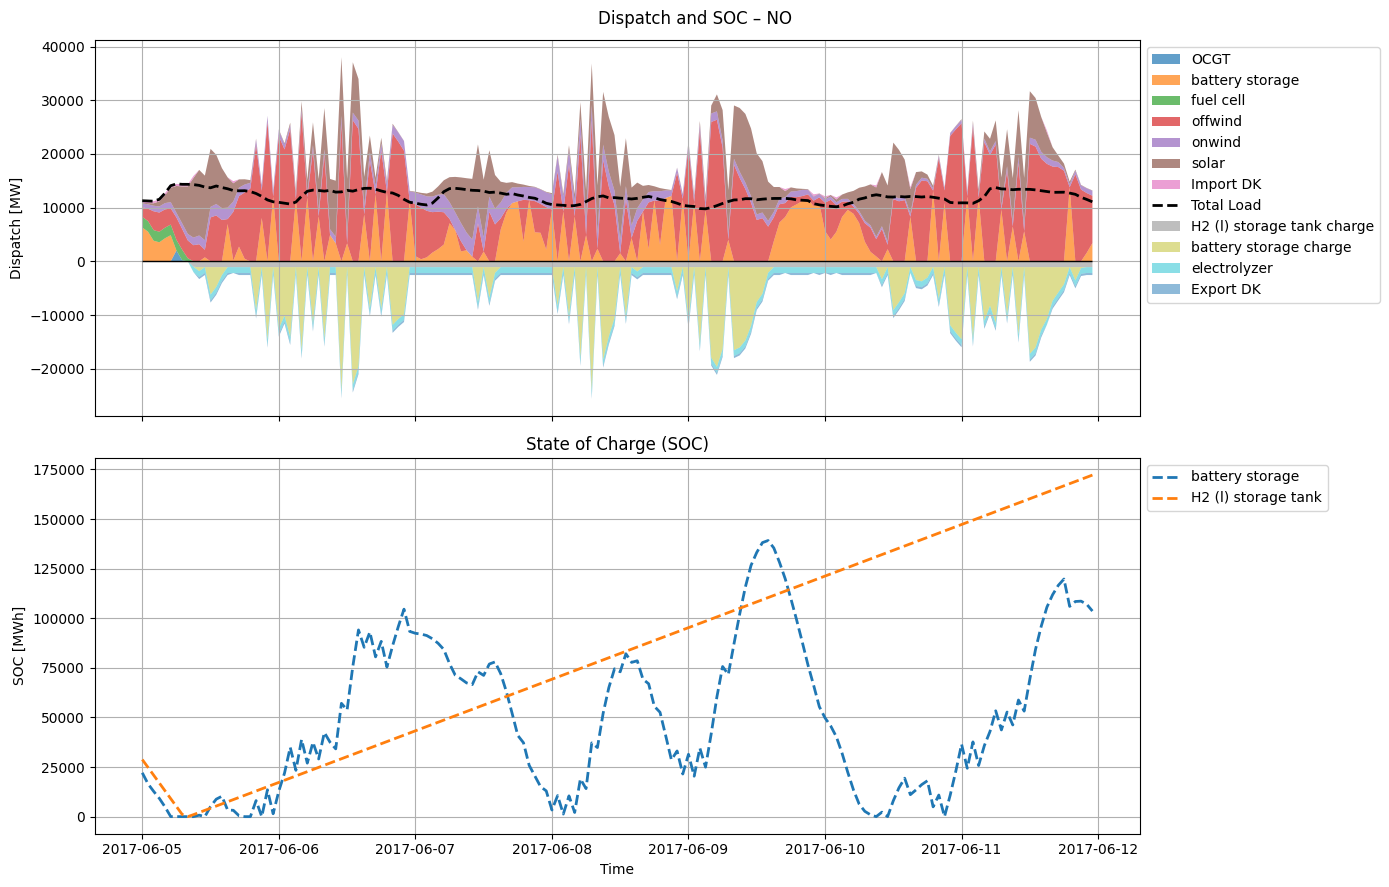

c:\Users\Jeppe Urup Byberg\OneDrive\Skrivebord\10. semester\Integrated Energy Grids\ieg_env\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x1ec62e2f8d0>,
 <matplotlib.collections.LineCollection at 0x1ec62dd51d0>)

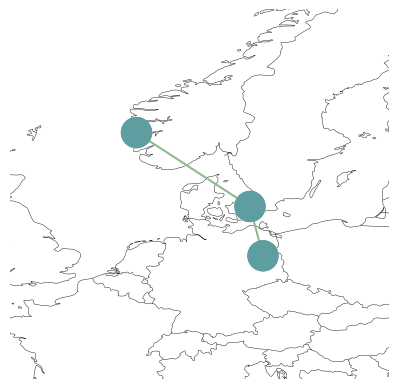

In [ ]:
from DispatchSoCInternational import PlotInternationalDispatchSoC
from ExpandedNetwork import ExpandedNetwork
from silent_optimize import silent_optimize
from AnnualElectricityMix import AnnualElectricityMix


year = 2017
cost_year = 2030
demand_year = 2019,
setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            },
        'DE': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            },
        'NO': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'offwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }
            }

International_Network = ExpandedNetwork(year = 2017, cost_year = 2030, setup = setup, demand_year=2019)
regions = list(International_Network.regions)

#Link between DK and DE
International_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[1]}",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = 1000, # max capacity is 1000 MW
             p_min_pu=-1,
             capital_cost=International_Network.costs.at['HVAC overhead', "capital_cost"] * 10000,
             ) 

#Link between DK and NO
International_Network.network.add("Link",
             f'{regions[0]} - {regions[2]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[2]}",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             capital_cost=International_Network.costs.at['HVDC submarine', "capital_cost"] * 10000
             ) 

co2_limits = {
    'DK': 5_000_000,
    'DE': 20_000_000,
    'NO': 6_000_000
}

for region, limit in co2_limits.items():
    carrier = f"gas {region}"
    International_Network.network.add(
        "GlobalConstraint",
        f"CO2Limit {region}",
        carrier_attribute="co2_emissions",
        sense="<=",
        carrier=carrier,
        constant=limit
    )

silent_optimize(International_Network.network)
AnnualElectricityMix(International_Network)
PlotInternationalDispatchSoC(International_Network, start="2017-06-05 00:00", end="2017-06-11 23:00")

c:\Users\Jeppe Urup Byberg\OneDrive\Skrivebord\10. semester\Integrated Energy Grids\ieg_env\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


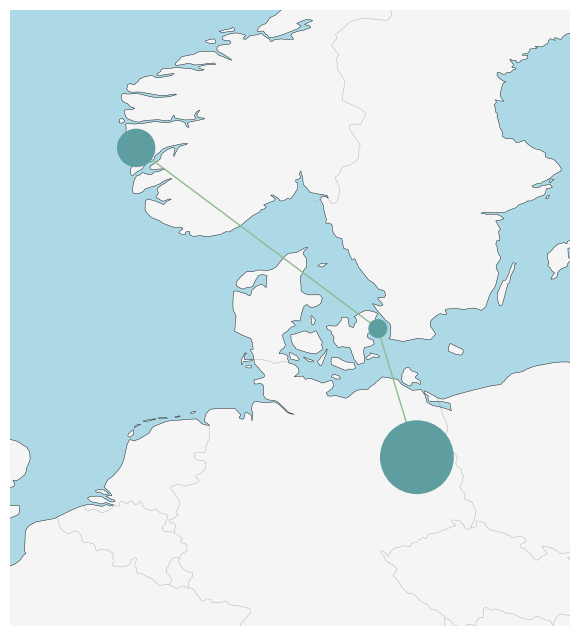

In [15]:
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
from shapely.errors import ShapelyDeprecationWarning

gen = International_Network.network.generators_t.p.mean().groupby(
    International_Network.network.generators.bus
).sum()

# Safe reindex to include all buses
gen = gen.reindex(International_Network.network.buses.index).fillna(0)

plt.figure(figsize=(12, 8))  # Adjust size here

International_Network.network.plot(
    bus_sizes=gen / 5e4,
    margin=0.5,
    line_widths=1,
    link_widths=1,
    projection=ccrs.EqualEarth(),
    color_geomap=True,
)
plt.show()


In [17]:
print(International_Network.network.global_constraints.constant) # CO2 limit (constant in the constraint)
print(International_Network.network.global_constraints.mu) # CO2 price (Lagrance multiplier in the constraint)

GlobalConstraint
CO2Limit DK     4000000.0
CO2Limit DE    20000000.0
CO2Limit NO     6000000.0
Name: constant, dtype: float64
GlobalConstraint
CO2Limit DK   -2339.333339
CO2Limit DE       0.000000
CO2Limit NO       0.000000
Name: mu, dtype: float64


# Task G

Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00,  8.65it/s]


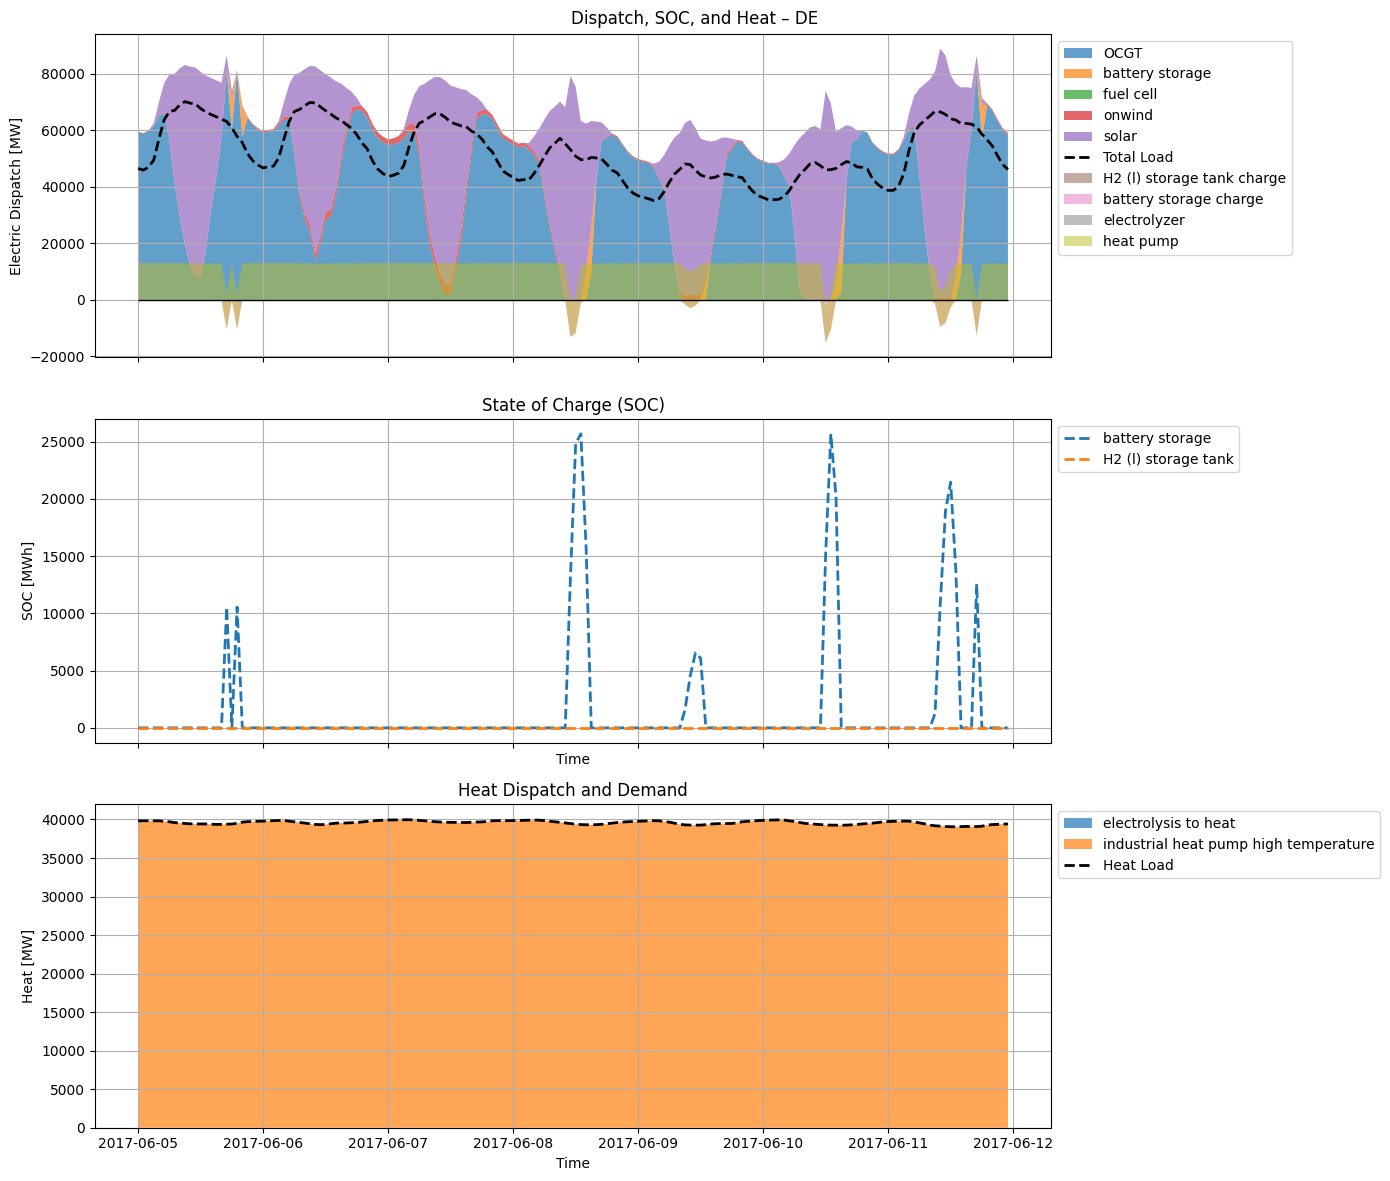

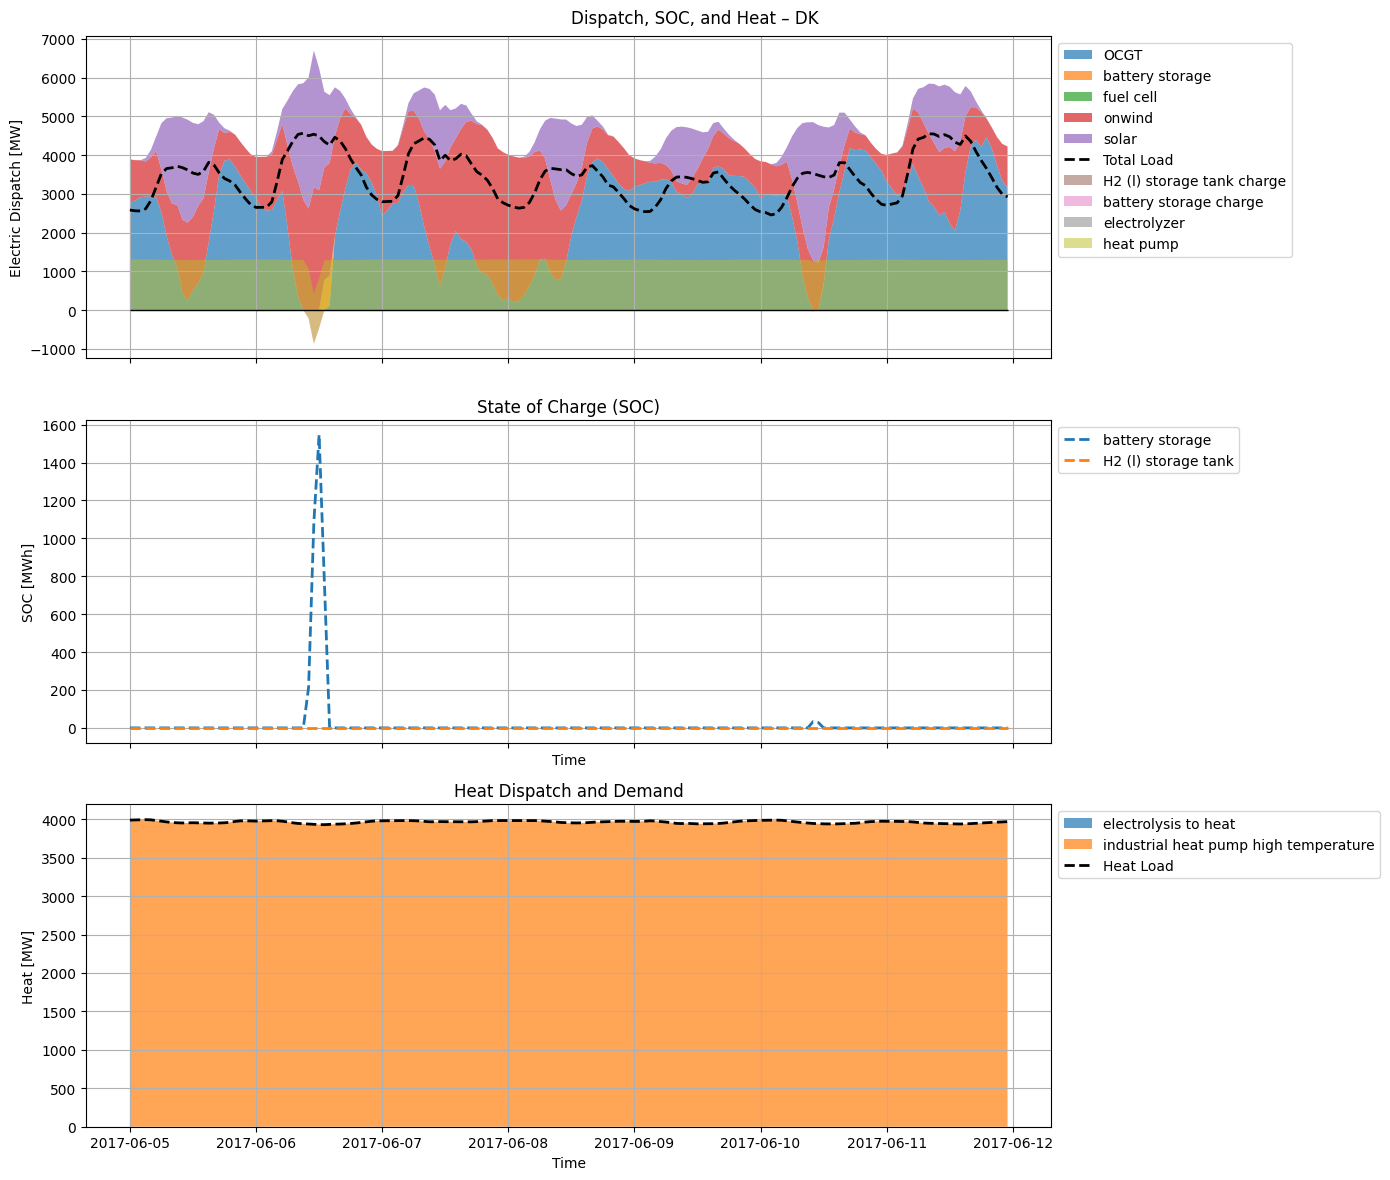

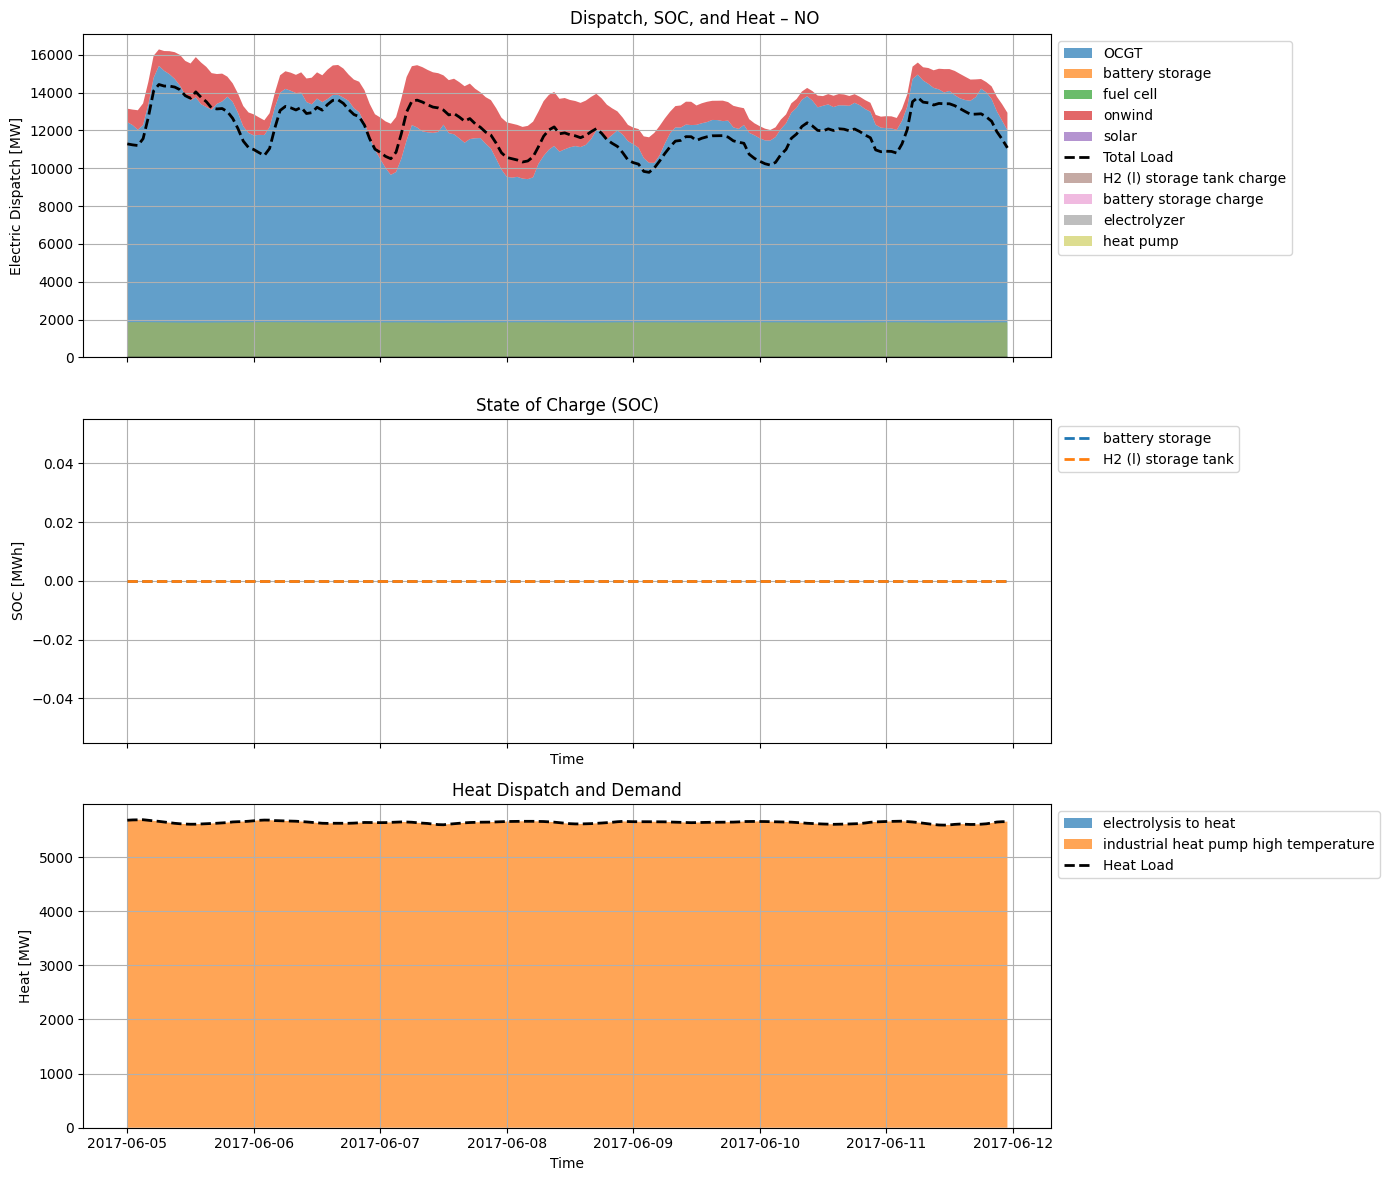

In [1]:
from ExpandedHeatNetwork import ExpandedHeatNetwork
from silent_optimize import silent_optimize
from DispatchSoCHeatInternational import PlotInternationalDispatchSoCHeat

setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            },
        'DE': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            },
        'NO': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            }
}

year = 2017
cost_year = 2030
demand_year = 2019,
Expanded_Heat_Network = ExpandedHeatNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)

silent_optimize(Expanded_Heat_Network.network)

PlotInternationalDispatchSoCHeat(Expanded_Heat_Network, start="2017-06-05 00:00", end="2017-06-11 23:00")

In [22]:
Expanded_Heat_Network.network.links_t.p1

Link,electrolysis to H2 DK,electrolysis to heat DK,fuel cell DK,industrial heat pump high temperature DK,electrolysis to H2 DE,electrolysis to heat DE,fuel cell DE,industrial heat pump high temperature DE,electrolysis to H2 NO,electrolysis to heat NO,fuel cell NO,industrial heat pump high temperature NO
snapshot,,,,,,,,,,,,
2017-01-01 00:00:00,-0.0,-0.0,-0.0,-4002.156275,-0.0,-0.0,-0.0,-40692.032974,-0.0,-0.0,-0.0,-5754.548176
2017-01-01 01:00:00,-0.0,-0.0,-0.0,-4001.984999,-0.0,-0.0,-0.0,-40714.867903,-0.0,-0.0,-0.0,-5757.607550
2017-01-01 02:00:00,-0.0,-0.0,-0.0,-4001.927907,-0.0,-0.0,-0.0,-40732.564972,-0.0,-0.0,-0.0,-5759.539786
2017-01-01 03:00:00,-0.0,-0.0,-0.0,-4002.099183,-0.0,-0.0,-0.0,-40757.112521,-0.0,-0.0,-0.0,-5759.942336
2017-01-01 04:00:00,-0.0,-0.0,-0.0,-4003.012652,-0.0,-0.0,-0.0,-40777.093083,-0.0,-0.0,-0.0,-5760.827944
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,-0.0,-0.0,-0.0,-4005.296325,-0.0,-0.0,-0.0,-39955.606528,-0.0,-0.0,-0.0,-5798.184510
2017-12-31 20:00:00,-0.0,-0.0,-0.0,-4008.265100,-0.0,-0.0,-0.0,-39967.594866,-0.0,-0.0,-0.0,-5791.180154
2017-12-31 21:00:00,-0.0,-0.0,-0.0,-4010.149131,-0.0,-0.0,-0.0,-39967.023993,-0.0,-0.0,-0.0,-5780.955404


In [ ]:
Expanded_Heat_Network.network.loads_t.p

Load,load DK,heat load DK,load DE,heat load DE,load NO,heat load NO
snapshot,,,,,,
2017-01-01 00:00:00,3186.04,4002.156275,41562.0,40692.032974,15622.94,5754.548176
2017-01-01 01:00:00,3070.07,4001.984999,40100.0,40714.867903,15705.29,5757.607550
2017-01-01 02:00:00,2966.19,4001.927907,38883.0,40732.564972,15643.08,5759.539786
2017-01-01 03:00:00,2933.48,4002.099183,38806.0,40757.112521,15611.87,5759.942336
2017-01-01 04:00:00,2940.64,4003.012652,38593.0,40777.093083,15727.78,5760.827944
...,...,...,...,...,...,...
2017-12-31 19:00:00,3785.27,4005.296325,47493.0,39955.606528,17343.36,5798.184510
2017-12-31 20:00:00,3582.21,4008.265100,45842.0,39967.594866,17013.44,5791.180154
2017-12-31 21:00:00,3438.26,4010.149131,45501.0,39967.023993,16530.47,5780.955404


In [9]:
Expanded_Heat_Network.network.links_t.p0

Link,electrolysis to H2 DK,electrolysis to heat DK,fuel cell DK,industrial heat pump high temperature DK,electrolysis to H2 DE,electrolysis to heat DE,fuel cell DE,industrial heat pump high temperature DE,electrolysis to H2 NO,electrolysis to heat NO,fuel cell NO,industrial heat pump high temperature NO
snapshot,,,,,,,,,,,,
2017-01-01 00:00:00,0.0,0.0,0.0,1312.182385,0.0,0.0,0.0,13341.650156,0.0,0.0,0.0,1886.737107
2017-01-01 01:00:00,0.0,0.0,0.0,1312.126229,0.0,0.0,0.0,13349.137017,0.0,0.0,0.0,1887.740180
2017-01-01 02:00:00,0.0,0.0,0.0,1312.107511,0.0,0.0,0.0,13354.939335,0.0,0.0,0.0,1888.373700
2017-01-01 03:00:00,0.0,0.0,0.0,1312.163667,0.0,0.0,0.0,13362.987712,0.0,0.0,0.0,1888.505684
2017-01-01 04:00:00,0.0,0.0,0.0,1312.463165,0.0,0.0,0.0,13369.538716,0.0,0.0,0.0,1888.796047
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,0.0,0.0,0.0,1313.211910,0.0,0.0,0.0,13100.198862,0.0,0.0,0.0,1901.044102
2017-12-31 20:00:00,0.0,0.0,0.0,1314.185279,0.0,0.0,0.0,13104.129464,0.0,0.0,0.0,1898.747591
2017-12-31 21:00:00,0.0,0.0,0.0,1314.802994,0.0,0.0,0.0,13103.942293,0.0,0.0,0.0,1895.395214


In [8]:
from CostGeneration import CostGeneration

costs = CostGeneration(year = 2030).costs

costs

parameter,C in fuel,C stored,CO2 intensity,CO2 stored,FOM,Motor size,VOM,ammonia-input,c_b,c_v,...,methanol-input,min_fill_level,naphtha-input,nitrogen-input,ore-input,p_nom_ratio,pelletizing cost,yield-biochar,marginal_cost,capital_cost
technology,,,,,,,,,,,,,,,,,,,,,
Ammonia cracker,NaN,NaN,0.0,NaN,4.3000,NaN,0.0000,1.46,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,144775.985816
BEV Bus city,NaN,NaN,0.0,NaN,0.0003,346.5517,0.0952,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0952,28012.052635
BEV Coach,NaN,NaN,0.0,NaN,0.0002,358.6207,0.0952,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0952,38152.112668
BEV Truck Semi-Trailer max 50 tons,NaN,NaN,0.0,NaN,0.0004,555.1724,0.0952,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0952,20814.213321
BEV Truck Solo max 26 tons,NaN,NaN,0.0,NaN,0.0002,382.7586,0.0952,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0952,32574.846501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uranium,NaN,NaN,0.0,NaN,0.0000,NaN,0.0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4122,0.000000
waste CHP,NaN,NaN,0.0,NaN,2.3550,NaN,28.0640,NaN,0.2918,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0640,938596.962679
waste CHP CC,NaN,NaN,0.0,NaN,2.3550,NaN,28.0640,NaN,0.2918,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0640,938596.962679


In [ ]:
year = 2017
cost_year = 2030
demand_year = 2019,
setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True},
        'DE': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            }}



Expanded_Network = ExpandedNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)
silent_optimize(Expanded_Network.network)
